<a href="https://colab.research.google.com/github/Santhosh-2308/Forest-Fire-Detection-using-ML/blob/main/ForestFireDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
!pip install tensorflow opencv-python matplotlib seaborn


In [4]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [5]:
!unzip -q archive.zip

In [8]:
import os
os.listdir()

['.config', 'archive.zip', 'fire_dataset', 'sample_data']

In [10]:
import os

In [11]:
os.makedirs('data/train/Fire', exist_ok=True)
os.makedirs('data/train/NoFire', exist_ok=True)
os.makedirs('data/val/Fire', exist_ok=True)
os.makedirs('data/val/NoFire', exist_ok=True)

In [13]:
import shutil
import random

def move_images(src_folder, dest_folder, label):
    files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(files)
    split = int(0.8 * len(files))  # 80% train, 20% val

    for i, file in enumerate(files):
        src = os.path.join(src_folder, file)
        if i < split:
            dst = os.path.join('data/train', label, file)
        else:
            dst = os.path.join('data/val', label, file)
        shutil.copy(src, dst)

# Move fire images
move_images('fire_dataset/fire_images', 'data', 'Fire')

# Move non-fire images
move_images('fire_dataset/non_fire_images', 'data', 'NoFire')


In [14]:
!ls data/train/Fire | wc -l
!ls data/val/Fire | wc -l
!ls data/train/NoFire | wc -l
!ls data/val/NoFire | wc -l


723
270
195
49


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory('data/train', target_size=(128,128), batch_size=32, class_mode='binary')
val_data = val_gen.flow_from_directory('data/val', target_size=(128,128), batch_size=32, class_mode='binary')


Found 918 images belonging to 2 classes.
Found 319 images belonging to 2 classes.


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7624 - loss: 0.5496 - val_accuracy: 0.9248 - val_loss: 0.2628
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9263 - loss: 0.1662 - val_accuracy: 0.9655 - val_loss: 0.1054
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9614 - loss: 0.1355 - val_accuracy: 0.9310 - val_loss: 0.1420
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9560 - loss: 0.1032 - val_accuracy: 0.9781 - val_loss: 0.0653
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9713 - loss: 0.0747 - val_accuracy: 0.9749 - val_loss: 0.1004
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9492 - loss: 0.1370 - val_accuracy: 0.9749 - val_loss: 0.0899
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9606 - loss: 0.0999 - val_accuracy: 0.9812 - val_loss: 0.0660
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9762 - loss: 0.0700 - val_accuracy: 0.9812 - val_loss:

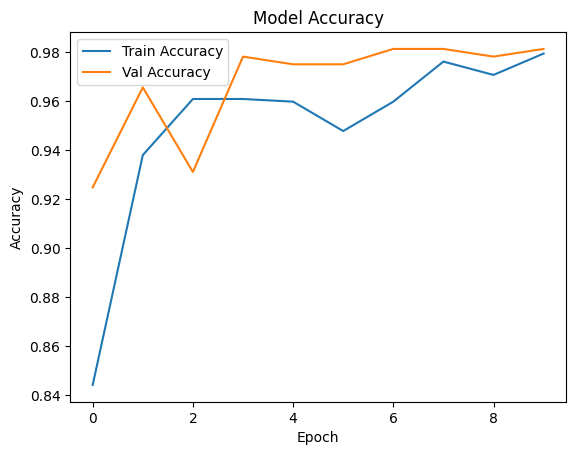

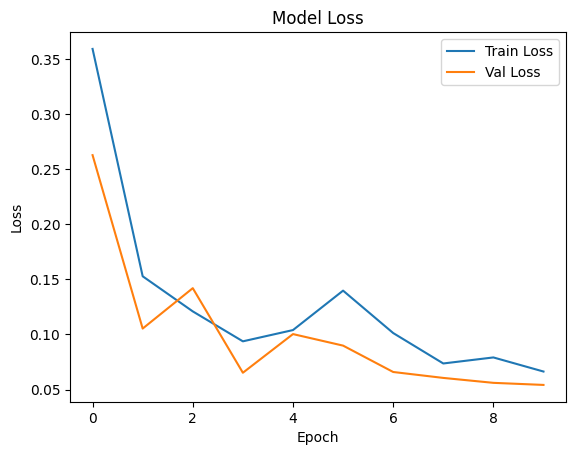

In [18]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [20]:
model.save('forest_fire_detection.keras')

In [52]:
from google.colab import files
uploaded = files.upload()  # Upload a fire or non-fire image here

Saving non_fire.6.png to non_fire.6 (1).png


In [53]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = list(uploaded.keys())[0]  # Get uploaded filename
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


In [54]:
if prediction[0][0] < 0.5:
    print("🔥 Fire Detected")
else:
    print("✅ No Fire Detected")


✅ No Fire Detected


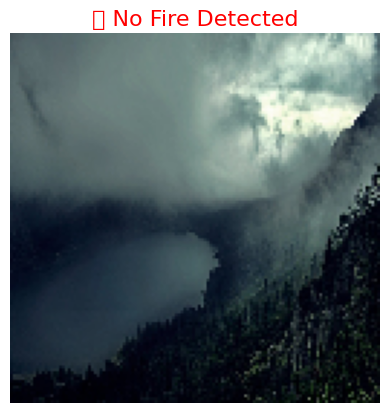

In [55]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(img)
plt.axis('off')

# Add title based on prediction
label = "🔥 Fire Detected" if prediction[0][0] < 0.5 else "✅ No Fire Detected"
plt.title(label, fontsize=16, color='red' if "Fire" in label else 'green')
plt.show()


In [40]:
print(train_data.class_indices)

{'Fire': 0, 'NoFire': 1}
